In [34]:
import torch
import torch.nn as nn
import PIL
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.patches as patches
from torchsummary import summary
import random

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
# import requests
# import zipfile
# import os
# from pycocotools.coco import COCO

# def download_coco(data_dir='coco', data_type='val2017', num_images=10):
#     # Create directories
#     if not os.path.exists(data_dir):
#         os.makedirs(data_dir)
#     img_dir = os.path.join(data_dir, data_type)
#     if not os.path.exists(img_dir):
#         os.makedirs(img_dir)

#     # URLs for images and annotations
#     base_url = 'http://images.cocodataset.org/'
#     ann_url = f'{base_url}annotations/annotations_trainval2017.zip'
#     img_url = f'{base_url}zips/{data_type}.zip'

#     # Download annotations
#     ann_zip_path = os.path.join(data_dir, 'annotations.zip')
#     with open(ann_zip_path, 'wb') as f:
#         f.write(requests.get(ann_url).content)
#     with zipfile.ZipFile(ann_zip_path, 'r') as zip_ref:
#         zip_ref.extractall(data_dir)
#     os.remove(ann_zip_path)

#     # Download images
#     img_zip_path = os.path.join(data_dir, f'{data_type}.zip')
#     with open(img_zip_path, 'wb') as f:
#         f.write(requests.get(img_url).content)
#     with zipfile.ZipFile(img_zip_path, 'r') as zip_ref:
#         img_files = zip_ref.namelist()
#         img_files = [f for f in img_files if f.endswith('.jpg')][:num_images]
#         for img_file in img_files:
#             zip_ref.extract(img_file, img_dir)
#     os.remove(img_zip_path)

#     print(f'Downloaded {num_images} images and annotations.')

# download_coco()


In [102]:
import json
import os

def filter_json_by_images(json_file_path, image_dir):
    # 지정된 디렉토리에서 이미지 파일 이름 가져오기
    image_files = {os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith('.jpg')}
    
    with open(json_file_path, 'r') as file:
        data = json.load(file)
        
        # 'images' 필드에서 지정된 이미지 파일과 일치하는 항목 필터링
        filtered_images = [img for img in data['images'] if os.path.splitext(img['file_name'])[0] in image_files]
        image_ids = {img['id'] for img in filtered_images}
        
        # 해당 image_id에 연결된 'annotations' 필드 필터링
        filtered_annotations = [ann for ann in data['annotations'] if ann['image_id'] in image_ids]
        
        # 필터링된 데이터를 새로운 JSON 파일로 저장
        filtered_data = {
            'info': data.get('info', {}),
            'licenses': data.get('licenses', []),
            'images': filtered_images,
            'annotations': filtered_annotations
        }
        
        with open('filtered_annotations.json', 'w') as output_file:
            json.dump(filtered_data, output_file, indent=4)

# 함수 호출
json_file_path = 'E:/puzzle/R-CNN(2014)/coco/annotations/instances_val2017.json'
image_dir = 'E:/puzzle/R-CNN(2014)/coco/val2017/val2017'
filter_json_by_images(json_file_path, image_dir)


In [103]:
model = torchvision.models.vgg16(pretrained=True).to(device)
features = list(model.features)

# only collect layers with output feature map size (W, H) < 50
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array

req_features = []
output = dummy_img.clone().to(device)

for feature in features:
    output = feature(output)
#     print(output.size()) => torch.Size([batch_size, channel, width, height])
    if output.size()[2] < 800//16: # 800/16=50
        break
    req_features.append(feature)
    out_channels = output.size()[1]

faster_rcnn_feature_extractor = nn.Sequential(*req_features)
print(faster_rcnn_feature_extractor(dummy_img.to(device)).shape)
# 결과 확인
summary(faster_rcnn_feature_extractor, (3, 800, 800))


torch.Size([1, 512, 50, 50])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 800, 800]           1,792
              ReLU-2         [-1, 64, 800, 800]               0
            Conv2d-3         [-1, 64, 800, 800]          36,928
              ReLU-4         [-1, 64, 800, 800]               0
         MaxPool2d-5         [-1, 64, 400, 400]               0
            Conv2d-6        [-1, 128, 400, 400]          73,856
              ReLU-7        [-1, 128, 400, 400]               0
            Conv2d-8        [-1, 128, 400, 400]         147,584
              ReLU-9        [-1, 128, 400, 400]               0
        MaxPool2d-10        [-1, 128, 200, 200]               0
           Conv2d-11        [-1, 256, 200, 200]         295,168
             ReLU-12        [-1, 256, 200, 200]               0
           Conv2d-13        [-1, 256, 200, 200]         590,080
          

In [104]:
# 앵커 박스 생성
feature_size = 800 // 16
ctr_x = np.arange(16, (feature_size + 1) * 16, 16)
ctr_y = np.arange(16, (feature_size + 1) * 16, 16)

# 앵커 박스 비율 및 스케일 설정
ratios = [0.5, 1, 2]  # 더 다양한 비율 추가
scales = [8, 16, 32]      # 더 많은 스케일 추가
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * len(ratios) * len(scales)), 4))
index = 0

for cx in ctr_x:
    for cy in ctr_y:
        for ratio in ratios:
            for scale in scales:

                h = sub_sample * scale * np.sqrt(ratio)
                w = sub_sample * scale * np.sqrt(1. / ratio)

                # anchor box [x1, y1, x2, y2]
                anchor_boxes[index, 1] = cy - h / 2.
                anchor_boxes[index, 0] = cx - w / 2.
                anchor_boxes[index, 3] = cy + h / 2.
                anchor_boxes[index, 2] = cx + w / 2.
                index += 1

index_inside = np.where(
    (anchor_boxes[:, 0] >= 0) &
    (anchor_boxes[:, 1] >= 0) &
    (anchor_boxes[:, 2] <= 800) &
    (anchor_boxes[:, 3] <= 800)
)[0]

valid_anchor_boxes = anchor_boxes[index_inside]

# 디버깅 출력을 통해 앵커 박스 확인
print(f"Number of valid anchor boxes: {len(valid_anchor_boxes)}")
print("First 5 valid anchor boxes:")
print(valid_anchor_boxes[1000:1005])

Number of valid anchor boxes: 9321
First 5 valid anchor boxes:
[[ 69.49033201 266.98066402 250.50966799 629.01933598]
 [ 69.49033201 418.745166   250.50966799 509.254834  ]
 [ 96.         400.         224.         528.        ]
 [ 32.         336.         288.         592.        ]
 [114.745166   373.49033201 205.254834   554.50966799]]


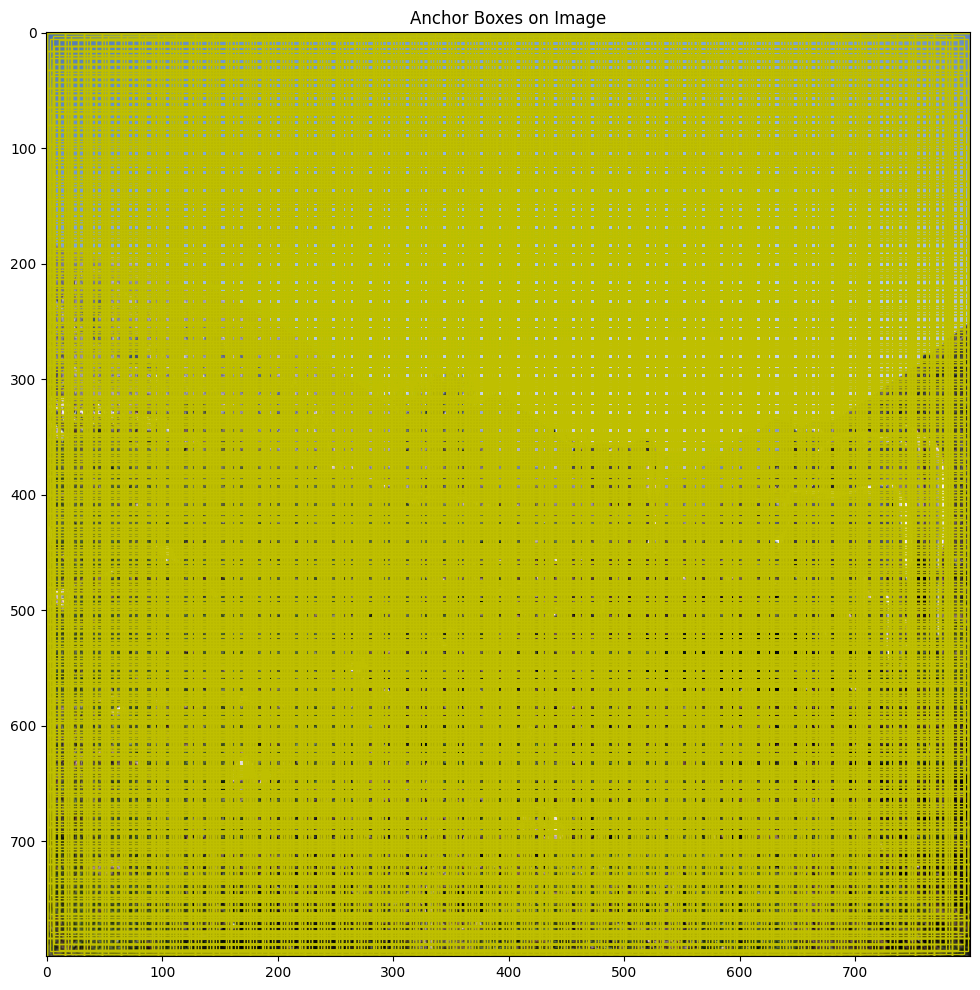

In [105]:
import PIL.Image as Image
# 샘플 이미지 파일 경로
image_dir = 'E:/puzzle/R-CNN(2014)/coco/val2017/val2017'
json_file_path = 'E:/puzzle/R-CNN(2014)/filtered_annotations.json'


# 이미지 파일 이름 리스트
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

# 샘플 이미지 선택
sample_image_file = image_files[2]  # 첫 번째 이미지 파일 선택
image_path = os.path.join(image_dir, sample_image_file)

# JSON 파일 로드
with open(json_file_path, 'r') as file:
    data = json.load(file)

# 이미지 ID 찾기
image_id = None
for img in data['images']:
    if img['file_name'] == sample_image_file:
        image_id = img['id']
        break

# 실제 객체 박스(ground truth box) 가져오기
gt_boxes = [ann for ann in data['annotations'] if ann['image_id'] == image_id]

# 이미지 로드 및 리사이즈
image = Image.open(image_path)
original_size = image.size
new_size = (800, 800)
image = image.resize(new_size)

# Annotation 박스 크기 조정
scale_x = new_size[0] / original_size[0]
scale_y = new_size[1] / original_size[1]
for ann in gt_boxes:
    ann['bbox'][0] *= scale_x
    ann['bbox'][1] *= scale_y
    ann['bbox'][2] *= scale_x
    ann['bbox'][3] *= scale_y

fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(image)

# 모든 앵커 박스 그리기
for box in valid_anchor_boxes:
    rect = patches.Rectangle(
        (box[0], box[1]), box[2] - box[0], box[3] - box[1],
        linewidth=1, edgecolor='y', facecolor='none'
    )
    ax.add_patch(rect)

plt.title("Anchor Boxes on Image")
plt.show()

In [108]:
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area

Positive Anchor Box found with IoU 0.6744278976210711: [608.0, 400.0, 128.0, 128.0] with [606.675, 388.43333333333334, 143.775, 168.96666666666667]
Positive Anchor Box found with IoU 0.6744278976210711: [608.0, 416.0, 128.0, 128.0] with [606.675, 388.43333333333334, 143.775, 168.96666666666667]
Positive Anchor Box found with IoU 0.6517993749081886: [608.0, 432.0, 128.0, 128.0] with [606.675, 388.43333333333334, 143.775, 168.96666666666667]
Positive Anchor Box found with IoU 0.6608637886098206: [624.0, 400.0, 128.0, 128.0] with [606.675, 388.43333333333334, 143.775, 168.96666666666667]
Positive Anchor Box found with IoU 0.6608637886098206: [624.0, 416.0, 128.0, 128.0] with [606.675, 388.43333333333334, 143.775, 168.96666666666667]


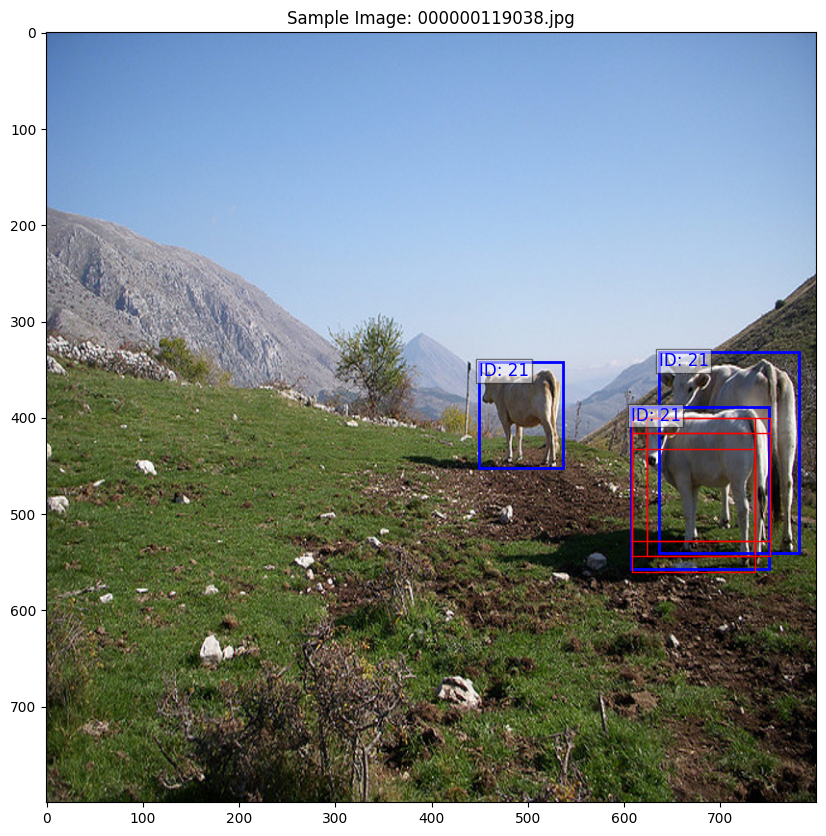

Annotation된 박스 (파란색):
[606.675, 388.43333333333334, 143.775, 168.96666666666667] Category ID: 21
[635.8, 331.40000000000003, 146.26250000000002, 208.91666666666666] Category ID: 21
[449.09999999999997, 342.08333333333337, 87.5, 110.33333333333334] Category ID: 21

Positive Anchor Boxes (빨간색):
[0.6744278976210711, array([608., 400., 736., 528.])]
[0.6744278976210711, array([608., 416., 736., 544.])]
[0.6517993749081886, array([608., 432., 736., 560.])]
[0.6608637886098206, array([624., 400., 752., 528.])]
[0.6608637886098206, array([624., 416., 752., 544.])]


In [111]:

# 라벨링 작업
labels = np.empty((len(valid_anchor_boxes),), dtype=np.int32)
labels.fill(-1)

# IoU 기준
pos_iou_threshold = 0.64
neg_iou_threshold = 0.3
positive_boxes = []
negative_boxes = []
# 디버깅 출력을 추가하여 IoU 계산이 올바르게 이루어지는지 확인
for gt_box in gt_boxes:
    # gt_box 좌표 변환 [x, y, width, height]로 변환 (JSON 형식이 [x, y, width, height]라고 가정)
    gt_x1, gt_y1, gt_width, gt_height = gt_box['bbox']
    gt_box_coords = [gt_x1, gt_y1, gt_width, gt_height]

    for idx, anchor in enumerate(valid_anchor_boxes):
        anchor_coords = [anchor[0], anchor[1], anchor[2] - anchor[0], anchor[3] - anchor[1]]
        iou = calculate_iou(anchor_coords, gt_box_coords)
        if iou >= pos_iou_threshold:
            labels[idx] = 1
            print(f"Positive Anchor Box found with IoU {iou}: {anchor_coords} with {gt_box_coords}")
            positive_boxes.append([iou, anchor])
        elif iou <= neg_iou_threshold:
            labels[idx] = 0
            negative_boxes.append([iou, anchor])

# 이미지에 박스 표시
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)

# 실제 객체 박스(파란색) 표시
for gt_box in gt_boxes:
    gt_x1, gt_y1, gt_width, gt_height = gt_box['bbox']
    category_id = gt_box['category_id']
    rect = patches.Rectangle((gt_x1, gt_y1), gt_width, gt_height, linewidth=2, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
    # 카테고리 ID 추가
    plt.text(gt_x1, gt_y1, f'ID: {category_id}', color='blue', fontsize=12, verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2})

# Positive Anchor Boxes (빨간색) 표시
for box in positive_boxes:
    x1, y1, x2, y2 = box[1]
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.title(f"Sample Image: {sample_image_file}")
plt.show()

# Annotation된 박스와 Positive Anchor Boxes 출력
print("Annotation된 박스 (파란색):")
for gt_box in gt_boxes:
    print(gt_box['bbox'], "Category ID:", gt_box['category_id'])

print("\nPositive Anchor Boxes (빨간색):")
for box in positive_boxes:
    print(box)

In [112]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
# 간단한 RPN 정의
class RPN(nn.Module):
    def __init__(self, in_channels, mid_channels, n_anchors):
        super(RPN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        self.score = nn.Conv2d(mid_channels, n_anchors * 2, 1, 1, 0)
        self.loc = nn.Conv2d(mid_channels, n_anchors * 4, 1, 1, 0)
        self._initialize_weights()
        
    def _initialize_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()
        self.score.weight.data.normal_(0, 0.01)
        self.score.bias.data.zero_()
        self.loc.weight.data.normal_(0, 0.01)
        self.loc.bias.data.zero_()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        rpn_locs = self.loc(x)
        rpn_scores = self.score(x)
        return rpn_locs, rpn_scores

# 예시 입력
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image_tensor = transform(image)
input_feature_map = faster_rcnn_feature_extractor(image_tensor.to(device))
rpn = RPN(in_channels=512, mid_channels=512, n_anchors=len(ratios) * len(scales)).to(device)

rpn_locs, rpn_scores = rpn(input_feature_map)
print(f"RPN Locations Shape: {rpn_locs.shape}")
print(f"RPN Scores Shape: {rpn_scores.shape}")


RPN Locations Shape: torch.Size([36, 50, 50])
RPN Scores Shape: torch.Size([18, 50, 50])


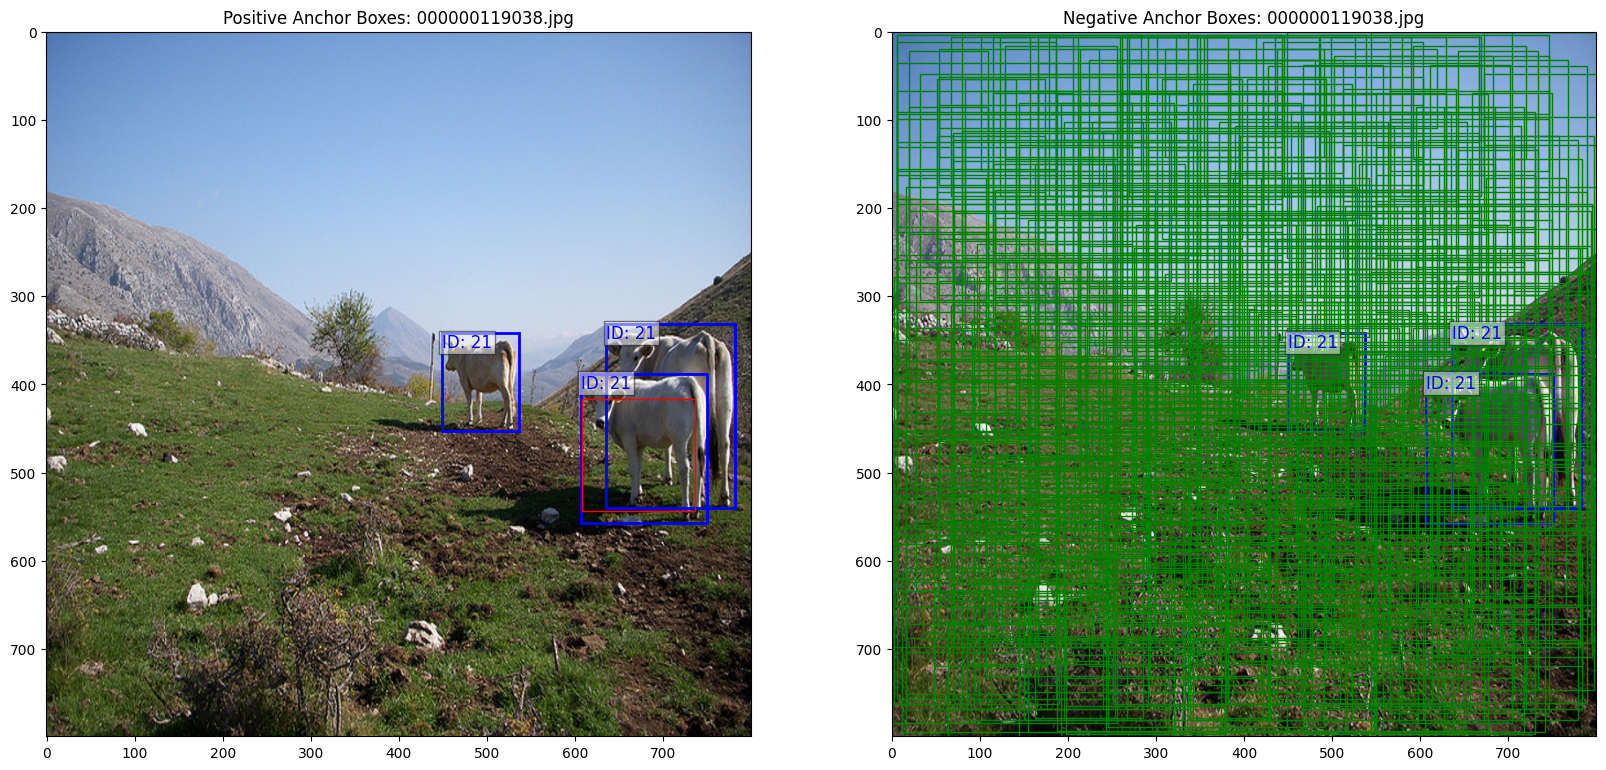

In [113]:
import numpy as np

def non_max_suppression(boxes, scores, iou_threshold):
    """
    Perform Non-Maximum Suppression (NMS) on the bounding boxes.
    
    Parameters:
        boxes (numpy.ndarray): Array of bounding boxes (N, 4) with (x1, y1, x2, y2)
        scores (numpy.ndarray): Array of scores (N,)
        iou_threshold (float): IoU threshold for NMS
        
    Returns:
        List[int]: Indices of the boxes to keep
    """
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    # 박스 정렬(내림차순)
    order = scores.argsort()[::-1]
    # 남긴 박스
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter)
        
        inds = np.where(iou <= iou_threshold)[0]
        order = order[inds + 1]
    
    return keep

# Positive Anchor Boxes NMS 적용
positive_boxes_array = np.array([box[1] for box in positive_boxes])
positive_scores_array = np.array([box[0] for box in positive_boxes])

positive_keep_indices = non_max_suppression(positive_boxes_array, positive_scores_array, iou_threshold=0.3)
positive_nms_boxes = positive_boxes_array[positive_keep_indices]

# Negative Anchor Boxes NMS 적용
negative_boxes_array = np.array([box[1] for box in negative_boxes])
negative_scores_array = np.array([box[0] for box in negative_boxes])

negative_keep_indices = non_max_suppression(negative_boxes_array, negative_scores_array, iou_threshold=0.5)
negative_nms_boxes = negative_boxes_array[negative_keep_indices]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# 첫 번째 이미지 (Positive Anchor Boxes)
ax1.imshow(image)
ax1.set_title(f"Positive Anchor Boxes: {sample_image_file}")

# 실제 객체 박스(파란색) 표시
for gt_box in gt_boxes:
    gt_x1, gt_y1, gt_width, gt_height = gt_box['bbox']
    category_id = gt_box['category_id']
    rect = patches.Rectangle((gt_x1, gt_y1), gt_width, gt_height, linewidth=2, edgecolor='blue', facecolor='none')
    ax1.add_patch(rect)
    ax1.text(gt_x1, gt_y1, f'ID: {category_id}', color='blue', fontsize=12, verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2})

# Positive Anchor Boxes (빨간색) 표시
for box in positive_nms_boxes:
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='red', facecolor='none')
    ax1.add_patch(rect)

# 두 번째 이미지 (Negative Anchor Boxes)
ax2.imshow(image)
ax2.set_title(f"Negative Anchor Boxes: {sample_image_file}")

# 실제 객체 박스(파란색) 표시
for gt_box in gt_boxes:
    gt_x1, gt_y1, gt_width, gt_height = gt_box['bbox']
    category_id = gt_box['category_id']
    rect = patches.Rectangle((gt_x1, gt_y1), gt_width, gt_height, linewidth=2, edgecolor='blue', facecolor='none')
    ax2.add_patch(rect)
    ax2.text(gt_x1, gt_y1, f'ID: {category_id}', color='blue', fontsize=12, verticalalignment='top', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2})

# Negative Anchor Boxes (초록색) 표시
for box in negative_nms_boxes:
    x1, y1, x2, y2 = box
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='green', facecolor='none')
    ax2.add_patch(rect)

plt.show()


In [126]:
class CustomCocoDataset(Dataset):
    def __init__(self, image_dir, json_file_path, mode='rpn', transform=None):
        super().__init__()
        self.image_dir = image_dir
        self.transform = transform
        self.mode = mode

        # JSON 파일 로드
        with open(json_file_path, 'r') as file:
            self.data = json.load(file)

        self.image_files = [img['file_name'] for img in self.data['images']]
        self.annotations = self.data['annotations']

        # 이미지 ID와 파일 이름 매핑
        self.image_id_map = {img['file_name']: img['id'] for img in self.data['images']}

        # 각 이미지에 대한 annotation 매핑
        self.image_annotations = {img_id: [] for img_id in self.image_id_map.values()}
        for ann in self.annotations:
            self.image_annotations[ann['image_id']].append(ann)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        sample_image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, sample_image_file)
        image_id = self.image_id_map[sample_image_file]

        # 이미지 로드 및 리사이즈
        image = Image.open(image_path).convert("RGB")
        original_size = image.size
        new_size = (512, 512)
        image = image.resize(new_size)

        # 실제 객체 박스(ground truth box) 가져오기 및 리사이즈
        gt_boxes = self.image_annotations[image_id]
        resized_gt_boxes = []
        for gt_box in gt_boxes:
            x, y, w, h = gt_box['bbox']
            x = x * new_size[0] / original_size[0]
            y = y * new_size[1] / original_size[1]
            w = w * new_size[0] / original_size[0]
            h = h * new_size[1] / original_size[1]
            resized_gt_boxes.append({'bbox': [x, y, w, h], 'category_id': gt_box['category_id']})

        if self.mode == 'rpn':
            # 앵커 박스 생성
            valid_anchor_boxes = self.generate_anchor_boxes(new_size)

            # Positive 박스 준비
            total_boxes, labels = self.prepare_positive_boxes(resized_gt_boxes, valid_anchor_boxes)

            # 바운딩 박스와 레이블 텐서로 변환
            boxes_tensor = torch.tensor(total_boxes, dtype=torch.float32)
            labels_tensor = torch.tensor(labels, dtype=torch.float32).view(-1)
        else:  # 'rcnn' 모드
            # 바운딩 박스와 레이블 텐서로 변환
            boxes_tensor, labels_tensor = self.prepare_rcnn_boxes(resized_gt_boxes)

        # 변환 적용
        if self.transform:
            image = self.transform(image)

        return image, boxes_tensor, labels_tensor

    def generate_anchor_boxes(self, image_size):
        feature_size = image_size[0] // 16
        ctr_x = np.arange(16, (feature_size + 1) * 16, 16)
        ctr_y = np.arange(16, (feature_size + 1) * 16, 16)
        ratios = [0.5, 1, 2]
        scales = [8, 16, 32]
        sub_sample = 16

        anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4))
        index = 0

        for cx in ctr_x:
            for cy in ctr_y:
                for ratio in ratios:
                    for scale in scales:
                        h = sub_sample * scale * np.sqrt(ratio)
                        w = sub_sample * scale * np.sqrt(1. / ratio)
                        anchor_boxes[index, 1] = cy - h / 2.
                        anchor_boxes[index, 0] = cx - w / 2.
                        anchor_boxes[index, 3] = cy + h / 2.
                        anchor_boxes[index, 2] = cx + w / 2.
                        index += 1

        index_inside = np.where(
            (anchor_boxes[:, 0] >= 0) &
            (anchor_boxes[:, 1] >= 0) &
            (anchor_boxes[:, 2] <= image_size[0]) &
            (anchor_boxes[:, 3] <= image_size[1])
        )[0]

        valid_anchor_boxes = anchor_boxes[index_inside]
        return valid_anchor_boxes

    def prepare_positive_boxes(self, gt_boxes, valid_anchor_boxes):
        pos_iou_threshold = 0.66

        positive_boxes = []
        labels = np.empty((len(valid_anchor_boxes),), dtype=np.int32)
        labels.fill(-1)

        for gt_box in gt_boxes:
            gt_x1, gt_y1, gt_width, gt_height = gt_box['bbox']
            gt_box_coords = [gt_x1, gt_y1, gt_x1 + gt_width, gt_y1 + gt_height]

            for idx, anchor in enumerate(valid_anchor_boxes):
                anchor_coords = [anchor[0], anchor[1], anchor[2], anchor[3]]
                iou = self.calculate_iou(anchor_coords, gt_box_coords)
                if iou >= pos_iou_threshold:
                    labels[idx] = gt_box['category_id']
                    positive_boxes.append(anchor_coords)

        # Positive 박스만 선택
        total_boxes = positive_boxes
        labels = [1] * len(positive_boxes)

        return total_boxes, labels

    def prepare_rcnn_boxes(self, gt_boxes):
        pos_iou_threshold = 0.66
        neg_iou_threshold = 0.3

        positive_boxes = []
        negative_boxes = []

        for gt_box in gt_boxes:
            gt_x1, gt_y1, gt_width, gt_height = gt_box['bbox']
            gt_box_coords = [gt_x1, gt_y1, gt_x1 + gt_width, gt_y1 + gt_height]

            for idx, anchor in enumerate(valid_anchor_boxes):
                anchor_coords = [anchor[0], anchor[1], anchor[2], anchor[3]]
                iou = self.calculate_iou(anchor_coords, gt_box_coords)
                if iou >= pos_iou_threshold:
                    positive_boxes.append([iou, anchor_coords, gt_box['category_id']])
                elif iou <= neg_iou_threshold:
                    negative_boxes.append(anchor_coords)

        # Positive Boxes에 NMS 적용
        if positive_boxes:
            pos_boxes_array = np.array([box[1] for box in positive_boxes])
            pos_scores_array = np.array([box[0] for box in positive_boxes])
            pos_keep_indices = self.non_max_suppression(pos_boxes_array, pos_scores_array, iou_threshold=0.3)
            positive_boxes = [positive_boxes[i] for i in pos_keep_indices]

        # Negative Boxes에 NMS 적용
        if negative_boxes:
            neg_boxes_array = np.array(negative_boxes)
            neg_scores_array = np.ones(len(negative_boxes))
            neg_keep_indices = self.non_max_suppression(neg_boxes_array, neg_scores_array, iou_threshold=0.5)
            negative_boxes = [negative_boxes[i] for i in neg_keep_indices]

        # Positive Box와 Negative Box의 개수를 조정하여 총 256개로 맞추기
        num_positive = min(128, len(positive_boxes))
        if num_positive < 128:
            num_negative = 256 - num_positive
        else:
            num_negative = 128

        positive_boxes = positive_boxes[:num_positive]
        negative_boxes = negative_boxes[:num_negative]

        # 총 256개의 박스 준비
        total_boxes = [box[1] for box in positive_boxes] + negative_boxes
        labels = [box[2] for box in positive_boxes] + [0] * len(negative_boxes)  # 라벨을 category_id로 설정

        boxes_tensor = torch.tensor(total_boxes, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.int64)

        return boxes_tensor, labels_tensor

    def calculate_iou(self, box1, box2):
        x1, y1, x2, y2 = box1
        x1g, y1g, x2g, y2g = box2

        # Calculate intersection
        xi1 = max(x1, x1g)
        yi1 = max(y1, y1g)
        xi2 = min(x2, x2g)
        yi2 = min(y2, y2g)
        inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)

        # Calculate union
        box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
        box2_area = (x2g - x1g + 1) * (y2g - y1g + 1)
        union_area = box1_area + box2_area - inter_area

        # Calculate IoU
        iou = inter_area / union_area
        return iou

    def non_max_suppression(self, boxes, scores, iou_threshold):
        if len(boxes) == 0:
            return []

        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]

        areas = (x2 - x1 + 1) * (y2 - y1 + 1)
        order = scores.argsort()[::-1]

        keep = []
        while order.size > 0:
            i = order[0]
            keep.append(i)
            xx1 = np.maximum(x1[i], x1[order[1:]])
            yy1 = np.maximum(y1[i], y1[order[1:]])
            xx2 = np.minimum(x2[i], x2[order[1:]])
            yy2 = np.minimum(y2[i], y2[order[1:]])

            w = np.maximum(0, xx2 - xx1 + 1)
            h = np.maximum(0, yy2 - yy1 + 1)

            inter = w * h
            iou = inter / (areas[i] + areas[order[1:]] - inter)

            inds = np.where(iou <= iou_threshold)[0]
            order = order[inds + 1]

        return keep

# 사용 예제
image_dir = 'E:/puzzle/R-CNN(2014)/coco/val2017/val2017'
json_file_path = 'E:/puzzle/R-CNN(2014)/filtered_annotations.json'
transform = transforms.Compose([
    transforms.Resize((800,800)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])  # 필요한 경우 torchvision.transforms를 사용하여 변환 적용

dataset = CustomCocoDataset(image_dir, json_file_path,mode='rpn' ,transform=transform)

# 데이터 로더 준비
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)  # num_workers를 0으로 설정하여 문제 확인

# 배치 단위로 데이터 확인
for images, boxes, labels in dataloader:
    print(images.shape)  # 이미지 텐서 크기 출력
    print(boxes.shape)  # 박스 텐서 크기 출력
    print(labels.shape)  # 라벨 텐서 크기 출력
    break

torch.Size([1, 3, 800, 800])
torch.Size([1, 0])
torch.Size([1, 0])


In [132]:
class RPN(nn.Module):
    def __init__(self, in_channels, mid_channels, n_anchors):
        super(RPN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        self.score = nn.Conv2d(mid_channels, n_anchors * 2, 1, 1, 0)
        self.loc = nn.Conv2d(mid_channels, n_anchors * 4, 1, 1, 0)
        self._initialize_weights()
        
    def _initialize_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()
        self.score.weight.data.normal_(0, 0.01)
        self.score.bias.data.zero_()
        self.loc.weight.data.normal_(0, 0.01)
        self.loc.bias.data.zero_()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        rpn_locs = self.loc(x)
        rpn_scores = self.score(x)
        return rpn_locs, rpn_scores

# 예시 입력
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image_tensor = transform(image)
input_feature_map = faster_rcnn_feature_extractor(image_tensor.to(device))
rpn = RPN(in_channels=512, mid_channels=512, n_anchors=len(ratios) * len(scales)).to(device)


In [134]:
print(summary(rpn, (512, 50, 50)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 50, 50]       2,359,808
            Conv2d-2           [-1, 36, 50, 50]          18,468
            Conv2d-3           [-1, 18, 50, 50]           9,234
Total params: 2,387,510
Trainable params: 2,387,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 4.88
Forward/backward pass size (MB): 10.80
Params size (MB): 9.11
Estimated Total Size (MB): 24.79
----------------------------------------------------------------
None


In [135]:
# Fast R-CNN 정의
class FastRCNN(nn.Module):
    def __init__(self, in_channels=512, num_classes=91):
        super(FastRCNN, self).__init__()
        self.roi_pool = nn.AdaptiveMaxPool2d((7, 7))  # RoI Pooling
        self.fc1 = nn.Linear(in_channels * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.cls_layer = nn.Linear(4096, num_classes)
        self.reg_layer = nn.Linear(4096, num_classes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x, rois):
        rois = self.roi_pool(rois)
        rois = rois.view(rois.size(0), -1)
        x = self.relu(self.fc1(rois))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        cls = self.cls_layer(x)
        reg = self.reg_layer(x)
        return cls, reg
    
fast_rcnn = FastRCNN().cuda()

In [142]:
# RPN과 VGG 통합
class RPNWithVGG(nn.Module):
    def __init__(self, features, rpn):
        super(RPNWithVGG, self).__init__()
        self.features = nn.Sequential(*features)
        self.rpn = rpn
    
    def forward(self, x):
        x = self.features(x)
        rpn_cls, rpn_reg = self.rpn(x)
        return rpn_cls, rpn_reg
    
# 모델 초기화
rpn_model = RPNWithVGG(faster_rcnn_feature_extractor, rpn).cuda()

print(summary(rpn_model, (3, 800, 800)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 800, 800]           1,792
              ReLU-2         [-1, 64, 800, 800]               0
            Conv2d-3         [-1, 64, 800, 800]          36,928
              ReLU-4         [-1, 64, 800, 800]               0
         MaxPool2d-5         [-1, 64, 400, 400]               0
            Conv2d-6        [-1, 128, 400, 400]          73,856
              ReLU-7        [-1, 128, 400, 400]               0
            Conv2d-8        [-1, 128, 400, 400]         147,584
              ReLU-9        [-1, 128, 400, 400]               0
        MaxPool2d-10        [-1, 128, 200, 200]               0
           Conv2d-11        [-1, 256, 200, 200]         295,168
             ReLU-12        [-1, 256, 200, 200]               0
           Conv2d-13        [-1, 256, 200, 200]         590,080
             ReLU-14        [-1, 256, 2

In [143]:
# 손실 함수 정의
class RPNLoss(nn.Module):
    def __init__(self):
        super(RPNLoss, self).__init__()
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.smooth_l1_loss = nn.SmoothL1Loss()
    
    def forward(self, cls_pred, cls_target, reg_pred, reg_target):
        cls_loss = self.cross_entropy_loss(cls_pred, cls_target)
        reg_loss = self.smooth_l1_loss(reg_pred, reg_target)
        return cls_loss + reg_loss

class FastRCNNLoss(nn.Module):
    def __init__(self):
        super(FastRCNNLoss, self).__init__()
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.smooth_l1_loss = nn.SmoothL1Loss()
    
    def forward(self, cls_pred, cls_target, reg_pred, reg_target):
        cls_loss = self.cross_entropy_loss(cls_pred, cls_target)
        reg_loss = self.smooth_l1_loss(reg_pred, reg_target)
        return cls_loss + reg_loss

rpn_criterion = RPNLoss()
fast_rcnn_criterion = FastRCNNLoss()

# Optimizer 정의
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)


In [146]:
num_epochs = 10

for epoch in range(num_epochs):
    for images, boxes, labels in dataloader:
        images = images.cuda()
        boxes = boxes.cuda()
        labels = labels.cuda().view(-1).long()  # 라벨을 long 타입으로 변환

        optimizer.zero_grad()
        print(images.shape)  # torch.Size([1, 3, 512, 512])
        print(boxes.shape)  # torch.Size([128, 4])
        print(boxes)
        print(labels)  # tensor of shape [128]

        pred_anchor_locs, pred_cls_scores = rpn_model(images)
        print(pred_cls_scores.shape)  # torch.Size([1, 18, 32, 32]) 형태 예상
        print(pred_anchor_locs.shape)  # torch.Size([1, 36, 32, 32]) 형태 예상

        # pred_anchor_locs 변환
        pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
        print(pred_anchor_locs.shape)  # torch.Size([1, 9216, 4])

        # pred_cls_scores 변환
        pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
        print(pred_cls_scores.shape)  # torch.Size([1, 32, 32, 18])

        objectness_score = pred_cls_scores.view(1, 32, 32, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
        print(objectness_score.shape)  # torch.Size([1, 9216])

        pred_cls_scores = pred_cls_scores.view(1, -1, 2)
        print(pred_cls_scores.shape)  # torch.Size([1, 9216, 2])

        # 손실 계산을 위해 라벨 크기를 출력 크기에 맞추기
        num_anchors_per_location = 9
        total_anchors = pred_cls_scores.size(1)

        # 앵커와 그라운드 트루스 매칭을 통해 라벨과 바운딩 박스를 확장
        labels_expanded = torch.zeros(total_anchors).cuda().long()
        boxes_expanded = torch.zeros(total_anchors, 4).cuda()

        # 긍정 앵커의 라벨과 바운딩 박스를 확장
        positive_indices = (labels == 1).nonzero(as_tuple=True)[0]
        for idx in positive_indices:
            for anchor in range(num_anchors_per_location):
                labels_expanded[idx * num_anchors_per_location + anchor] = 1
                boxes_expanded[idx * num_anchors_per_location + anchor, :] = boxes[idx, :]

        # Foreground와 Background를 구분할 Binary Classification을 위해 라벨 조정
        labels_cls = labels_expanded.clone()

        # 샘플링
        positive_samples = torch.where(labels_cls == 1)[0]
        negative_samples = torch.where(labels_cls == 0)[0]

        num_positive_samples = min(128, len(positive_samples))
        num_negative_samples = 256 - num_positive_samples

        sampled_positive_indices = positive_samples[torch.randperm(len(positive_samples))[:num_positive_samples]]
        sampled_negative_indices = negative_samples[torch.randperm(len(negative_samples))[:num_negative_samples]]

        sampled_indices = torch.cat([sampled_positive_indices, sampled_negative_indices])

        # 샘플링된 앵커를 기반으로 손실 계산
        loss_cls = F.cross_entropy(pred_cls_scores.view(-1, 2)[sampled_indices], labels_cls[sampled_indices])
        loss_reg = F.smooth_l1_loss(pred_anchor_locs.view(-1, 4)[sampled_indices], boxes_expanded[sampled_indices])

        loss = loss_cls + loss_reg

        loss.backward()
        optimizer.step()


torch.Size([1, 3, 800, 800])
torch.Size([1, 41, 4])
tensor([[[  5.4903,  10.9807, 186.5097, 373.0193],
         [  5.4903,  26.9807, 186.5097, 389.0193],
         [  5.4903,  42.9807, 186.5097, 405.0193],
         [  5.4903,  58.9807, 186.5097, 421.0193],
         [  5.4903,  74.9807, 186.5097, 437.0193],
         [ 21.4903,  10.9807, 202.5097, 373.0193],
         [ 21.4903,  26.9807, 202.5097, 389.0193],
         [ 21.4903,  42.9807, 202.5097, 405.0193],
         [ 21.4903,  58.9807, 202.5097, 421.0193],
         [ 21.4903,  74.9807, 202.5097, 437.0193],
         [ 37.4903,  10.9807, 218.5097, 373.0193],
         [ 37.4903,  26.9807, 218.5097, 389.0193],
         [ 37.4903,  42.9807, 218.5097, 405.0193],
         [ 37.4903,  58.9807, 218.5097, 421.0193],
         [ 37.4903,  74.9807, 218.5097, 437.0193],
         [293.4903,  10.9807, 474.5097, 373.0193],
         [293.4903,  26.9807, 474.5097, 389.0193],
         [293.4903,  42.9807, 474.5097, 405.0193],
         [293.4903,  58.9807, 

RuntimeError: shape '[1, 32, 32, 9, 2]' is invalid for input of size 45000

In [74]:
# Fast R-CNN 학습
for epoch in range(num_epochs):
    for images, boxes, labels in dataloader:
        images = images.cuda()
        rois = rpn(images)  # RPN에서 RoI 추출
        labels = labels.cuda()
        
        optimizer.zero_grad()
        
        cls, reg = fast_rcnn(images, rois)
        loss_cls = criterion_cls(cls.view(-1, num_classes), labels.view(-1).long())  # classification loss
        loss_reg = criterion_reg(reg, boxes)  # regression loss
        loss = loss_cls + loss_reg  # total Fast R-CNN loss
        
        loss.backward()
        optimizer.step()

RuntimeError: Given groups=1, weight of size [512, 512, 3, 3], expected input[1, 3, 512, 512] to have 512 channels, but got 3 channels instead